# Setup

In [1]:
# import your standard packages
%run ../../../global_tools/start.py

# import your local functions
sys.path.insert(1, '../../code/')
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline


Default libraries loaded.


# Paths and Parameters

In [2]:
outfn = '../../data/chl_to_sla.nc'

# Read Data

In [3]:
# SLA
ds_SLA = xr.open_dataset('../../data/sla_processed.nc')
ds_SLA

<xarray.Dataset>
Dimensions:           (day_time: 10013, lat: 138, loc_list: 5, lon: 216, month: 12, no_stations: 367, time: 329)
Coordinates:
  * lon               (lon) float64 48.62 48.88 49.12 ... 101.9 102.1 102.4
  * lat               (lat) float64 -1.375 -1.125 -0.875 ... 32.38 32.62 32.88
  * time              (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2020-05-01
  * day_time          (day_time) datetime64[ns] 1993-01-01 ... 2020-05-31
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * no_stations       (no_stations) float64 1.0 2.0 3.0 ... 365.0 366.0 367.0
  * loc_list          (loc_list) int64 0 75 225 313 366
Data variables:
    daily_sla         (day_time, lat, lon) float64 ...
    mon_sla           (time, lat, lon) float64 ...
    mon_sla_mon_clim  (month, lat, lon) float64 ...
    mon_sla_mon_anom  (time, lat, lon) float64 ...
    sta_loninds       (no_stations) int64 ...
    sta_latinds       (no_stations) int64 ...
    sta_lon           (no_station

In [4]:
ds_CHL = xr.open_dataset('../../data/chl_processed.nc')
ds_CHL

<xarray.Dataset>
Dimensions:           (lat: 828, lon: 1296, month: 12, time: 273)
Coordinates:
  * lon               (lon) float64 48.52 48.56 48.6 48.65 ... 102.4 102.4 102.5
  * lat               (lat) float64 -1.479 -1.438 -1.396 ... 32.9 32.94 32.98
  * time              (time) datetime64[ns] 1997-09-04 1997-10-01 ... 2020-05-01
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    mon_chl           (time, lat, lon) float64 ...
    mon_chl_mon_clim  (month, lat, lon) float64 ...
    mon_chl_mon_anom  (time, lat, lon) float64 ...

# Regrid

In [5]:
xx,yy = np.meshgrid(ds_CHL.lon,ds_CHL.lat)
xx = xx.flatten()
yy = yy.flatten()

xx_SLA,yy_SLA = np.meshgrid(ds_SLA.lon,ds_SLA.lat)

mon_chl_mon_anom_SLA = np.zeros((len(ds_CHL.time),len(ds_SLA.lat),len(ds_SLA.lon)))*np.nan

for tt in tqdm(range(len(ds_CHL.time))):

    temp_chl = np.array(ds_CHL.mon_chl_mon_anom[tt,:,:])

    points = np.array( (xx,yy) ).T
    temp_values = temp_chl.flatten()

    mon_chl_mon_anom_SLA[tt,:,:] = griddata(points, temp_values, (xx_SLA,yy_SLA) ,method='linear')

ds_out = xr.Dataset(coords={'time': ds_CHL.time,
                        'lon': ds_SLA.lon,
                        'lat': ds_SLA.lat})
coords = [ds_CHL.time,ds_SLA.lat,ds_SLA.lon]
dims = ['time','lat','lon']

# add to dataset
ds_out['mon_chl_mon_anom'] = xr.DataArray(mon_chl_mon_anom_SLA,dims = dims,coords = coords)

100%|██████████| 273/273 [1:40:23<00:00, 21.92s/it]


In [6]:
xx,yy = np.meshgrid(ds_CHL.lon,ds_CHL.lat)
xx = xx.flatten()
yy = yy.flatten()

xx_SLA,yy_SLA = np.meshgrid(ds_SLA.lon,ds_SLA.lat)

mon_chl_mon_clim_SLA = np.zeros((len(ds_CHL.month),len(ds_SLA.lat),len(ds_SLA.lon)))*np.nan

for tt in tqdm(range(len(ds_CHL.month))):

    temp_chl = np.array(ds_CHL.mon_chl_mon_clim[tt,:,:])

    points = np.array( (xx,yy) ).T
    temp_values = temp_chl.flatten()

    mon_chl_mon_clim_SLA[tt,:,:] = griddata(points, temp_values, (xx_SLA,yy_SLA) ,method='linear')

coords = [ds_CHL.month,ds_SLA.lat,ds_SLA.lon]
dims = ['month','lat','lon']

# add to dataset
ds_out['mon_chl_mon_clim'] = xr.DataArray(mon_chl_mon_clim_SLA,dims = dims,coords = coords)

100%|██████████| 12/12 [04:23<00:00, 21.96s/it]


# Sample Plot

Text(0.5, 1.0, 'Original')

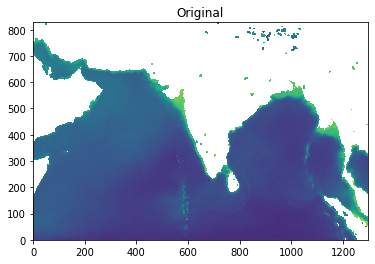

In [10]:
plt.pcolor(ds_CHL.mon_chl_mon_clim[0,:,:], norm = LogNorm())
plt.title('Original')

Text(0.5, 1.0, 'Regridded')

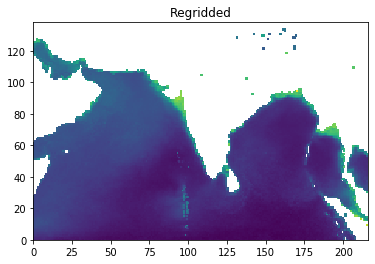

In [11]:
plt.pcolor(ds_out.mon_chl_mon_clim[0,:,:], norm = LogNorm())
plt.title('Regridded')

# SAVE

In [9]:
# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds_out.to_netcdf(outfn,mode='w',format = "NETCDF4")
ds_out

<xarray.Dataset>
Dimensions:           (lat: 138, lon: 216, month: 12, time: 273)
Coordinates:
  * time              (time) datetime64[ns] 1997-09-04 1997-10-01 ... 2020-05-01
  * lon               (lon) float64 48.62 48.88 49.12 ... 101.9 102.1 102.4
  * lat               (lat) float64 -1.375 -1.125 -0.875 ... 32.38 32.62 32.88
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    mon_chl_mon_anom  (time, lat, lon) float64 -0.09999 -0.1416 ... nan nan
    mon_chl_mon_clim  (month, lat, lon) float64 0.2111 0.1969 0.2055 ... nan nan